# Impact Function Calibration

Here is a walkthrough of the NCCS calibration module.

The structure and naming mirrors the CLIMADA calibration module, but this addds flexibility and functionality to calibrate entire model pipelines and heterogeneous observations.


In [1]:
# Import

import logging
import climada
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import copy
import os
import pycountry
from sklearn.metrics import mean_squared_log_error
from climada.util import log_level
from climada.entity import ImpactFuncSet, ImpfTropCyclone

logging.getLogger("climada").setLevel("INFO")
warnings.filterwarnings("ignore", category=DeprecationWarning)

LOGGER = logging.getLogger(__name__)

/usr/local/Caskroom/miniforge/base/envs/nccs_dev_jupyter/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


## User-supplied components of an NCCS calibration

The input to an NCCS calibration looks like this:

```
input = NCCSInput(
    config = config_template,
    data = obs,
    write_impact_functions = write_regional_tc_impact_function,
    return_period_impacts_from_config = return_period_impacts_from_config,
    cost_func = rp_rmse,
    bounds = bounds,
    constraints = constraints,
    linear_param='scale'
)
```

We'll go through these components one by one

### 1. Config template

A calibration will run the modelling pipeline many times, each time sampling from the parameter space we're exploring and optimising, each time giving different impact functions.

The `config_template` describes the model pipeline that will be run each time. The code will update the run's name each time the model is called so taht outputs are stored separately.

The impact functions themselves are _not_ contained in the config file. The `"calibrated": "custom"` entry says that impact functions should be read from a file, which the calibration will provide each time the model is called.

In [4]:
# NCCS model config

import pathos as pa
ncpus = 3
ncpus = pa.helpers.cpu_count() - 2

config_template = {
    "run_title": "calibration_v1/TC/SI/TC_SI_",
    "n_sim_years": 0,                   # (We don't do this part of the pipeline)
    "io_approach": [],                  # (We don't do this part of the pipeline)
    "force_recalculation": False,
    "use_s3": False,
    "log_level": "WARNING",
    "seed": 161,

    # Which parts of the model chain to run:
    "do_direct": True,                  # Calculate direct impacts (that aren't already calculated)
    "do_yearsets": False,               # Calculate direct impact yearsets (that aren't already calculated)
    "do_multihazard": False,            # Also combine hazards to create multi-hazard supply chain shocks
    "do_indirect": False,               # Calculate any indirect supply chain impacts (that aren't already calculated)

    # Impact functions:
    "business_interruption": False,     # Turn off to assume % asset loss = % production loss. Mostly for debugging and reproducibility
    "calibrated": "custom",             # Custom impacts

    # Parallisation:
    "do_parallel": True,                # Parallelise some operations
    "ncpus": ncpus,

    "runs": [
        {
            "hazard": "tropical_cyclone",
            "io_approach": [],
            "sectors": ["economic_assets"],
            "countries": countries,
            "scenario_years": [
                {"scenario": "None", "ref_year": "historical"},
            ],
        },
    ]
}

## 2. Observation data

The observations are prepared by scripts in the resources/calibration_calculations/observations_calculations/ folder and stored in the resources/calibration_calculations/observations_calculations/ folder.

For TCs all observations are currently of the form region - country - event_id - return period - impact (USD), extracted from EM-DAT.

The calibration of the impact functions will compare modelled return period losses to the these observations.

This calibration is for the Southern Indian ocean `SI` region because it's computationally quite cheap.

In [15]:
# Load observations

obs = pd.read_csv("../../resources/calibration_calculations/observations_data/tc.csv")
obs = obs[(obs["cal_region2"] == "SI")]

countries_iso3alpha = obs['country'].unique()
countries = [pycountry.countries.get(alpha_3=c).name for c in countries_iso3alpha]
n_years =max(obs['rp'])

obs

,country,cal_region2,event_id,impact,rp
202,MDG,SI,1984094S10080,9.077708e+08,38.000000
203,MDG,SI,1981351S12060,7.422745e+08,19.000000
204,MDG,SI,2004061S12072,6.114618e+08,12.666667
205,MDG,SI,1986067S11080,4.913706e+08,9.500000
206,MDG,SI,2007066S12066,3.488589e+08,7.600000
207,MDG,SI,1997018S11059,1.505103e+08,6.333333
208,MDG,SI,2012039S14075,1.075983e+08,5.428571
209,MDG,SI,1983339S10065,7.598812e+07,4.750000
210,MDG,SI,2008037S10055,6.803472e+07,4.222222
211,MDG,SI,1994007S16056,3.585277e+07,3.800000


# 3. `write_impact_functions`: a method to write custom impact functions from sampled input parameters

This is the model pipeline setup stage. Any changes to the model inputs and pipeline before it's run are made here, based on the sampled parameters for this run of the model. 

Currently this means writing impact functions defined by the input parameters to a file that is read in during the impact calculations.

In [5]:
import sys
import json
from climada.entity import ImpactFuncSet, ImpfTropCyclone
from climada.engine import Impact

sys.path.append('../..')
from utils.folder_naming import get_resources_dir, get_direct_output_dir
from analysis import run_pipeline_from_config


# def write_regional_tc_impact_function(v_thresh, v_half, scale):
def write_regional_tc_impact_function(v_half, scale):
    v_thresh = 25.8
    tc_impf_df = pd.DataFrame(dict(v_thresh=[v_thresh], v_half=[v_half], scale=[scale]))
    tc_impf_path = Path(get_resources_dir(), 'impact_functions', 'tropical_cyclone', 'custom.csv')
    tc_impf_df.to_csv(tc_impf_path, index=False)

## 4. `return_period_impacts_from_config`: a method to reproduce the observations with the model

This is the most complex part of the setup.

Given the observations that we have (and given that they might be very heterogeneous: a bunch of summary statistics gathered from the literature), we need a method that runs the NCCS modelling pipeline and then reads in the results to recreate the observations.

The output of this method will be used as input to the following `cost_func` cost function, which we also supply (so there is some flexibility).

The method below takes a config file (the optimizer takes the config template and generates a new config for each iteration). It runs the model pipeline and then reads the output, calculating return period losses by country to match the observations we have.

In [ ]:
def return_period_impacts_from_config(config):
    # Run the pipeline
    analysis_df = run_pipeline_from_config(config)

    # Load results to match the observations
    countries = config['runs'][0]['countries']
    imp_path_country = {country: list(analysis_df[analysis_df['country']==country]['direct_impact_path'])[0] for country in countries}
    imp_country = [
        pd.DataFrame({
            'country': pycountry.countries.get(name=country).alpha_3,
            'impact': Impact.from_hdf5(imp_path_country[country]).at_event
            })
        for country in countries
        ]
    
    for imp in imp_country:
        if not np.any([imp['impact']]):
            LOGGER.warning(f'No modelled impacts in country {imp["country"][0]}')

    df = pd.concat(imp_country)
    df = df.sort_values(['country', 'impact'], ascending=[True, False])
    df['rank'] = df.groupby(['country']).cumcount() + 1
    df['rp'] = n_years / df['rank']
    df = df[['country', 'impact', 'rp']]
    df = df.reset_index()
    return df

## 5. The cost function

This is a method that takes two dataframes: the observations and the observations as reproduced by the model. It aligns them and calculates some measure of the 'difference' between them (a 0 is a perfect reproduction, and higher values mean the model is worse. Note this is different from optimizations that want to maximize the objective function: the code accounts for this).

In this case we use the root mean square error which is provided by a util function in `calibration.rp_errors`.

There are three decisions/assumptions worth noting in this choice of cost function:
- we use the root mean square error to evaluate model performance (not the log). This means that error from small events aren't very important and errors from large events dominate the cost function. This is what we want. (Other options to consider: root_mean_squared_log_error, mean_squared_error)
- all return periods are weighted equally. If we want to weight towards more extreme events we can reconsider this
- all events are weighted equally. That means that countries with more events (and therefore more observations) have a stronger effect on the calibration

## 6. The input parameter bounds

These provide a permitted range for each parameter we're working with. It's a dictionary giving bounds for each parameter.

In [6]:
# bounds = {"v_thresh": (25.8, 25.8), "v_half": (25.8, 150), "scale": (0.01, 1)}
bounds = {"v_half": (25.81, 150), "scale": (0.01, 1)}

# Constraints

The BayesianOptimization also takes `constraints`. These can also be provided here. There are no constraints in this run.

# Linear parameter

The `linear_param` parameter is new to the NCCS calibration.

If you know that the impacts in the data frame produced by the `return_period_impacts_from_config` method are linear in one of the input parameters, specify that here.

For most impact functions that we'll look at in NCCS there will be a `scale` parameter which provides a linear scaling to the impacts. So we specify this here.

The modelling pipeline is set up to recognise that adjustments to this parameter are extremely cheap and so it samples generously when this is the case.

# Run the calibration

Now we can put this all together!

In [7]:
from climada.util import log_level

from calibration.base import NCCSInput
from calibration.bayesian_optimizer import NCCSBayesianOptimizer, NCCSBayesianOptimizerController
from calibration.rp_errors import rp_rmse

logging.getLogger('calibration').setLevel(logging.DEBUG)


# Define calibration input
with log_level("WARNING", name_prefix="climada"):
    with log_level("INFO", name_prefix="climada.util.calibrate"):
        input = NCCSInput(
            config = config_template,
            data = obs,
            write_impact_functions = write_regional_tc_impact_function,
            return_period_impacts_from_config = return_period_impacts_from_config,
            cost_func = rp_rmse,
            bounds = bounds,
            constraints = constraints,
            linear_param='scale'
            # results_file='SI_results.csv'
        )

        # Create and run the optimizer
        opt = NCCSBayesianOptimizer(input)
        controller = NCCSBayesianOptimizerController.from_input(input)
        bayes_output = opt.run(controller)
        bayes_output.params  # The optimal parameters

2024-09-25 22:33:16,544 - calibration.base - DEBUG - Creating the NCCSInput object
2024-09-25 22:33:16,544 - calibration.bayesian_optimizer - DEBUG - Initialising the NCCSBayesianOptimizer
2024-09-25 22:33:16,545 - calibration.base - DEBUG - Initialising an NCCSOptimizer with a cache
2024-09-25 22:33:16,546 - calibration.bayesian_optimizer - DEBUG - Initialising the NCCSBayesianOptimization
2024-09-25 22:33:16,547 - calibration.bayesian_optimizer - DEBUG - Starting the execution of the NCCSBayesianOptimizer
2024-09-25 22:33:16,549 - calibration.bayesian_optimizer - INFO - Gathering any data saved from previous runs in /Users/chrisfairless/Projects/CelsiusPro/nccs-supply-chain/results/calibration_v1/TC/SI
2024-09-25 22:33:16,550 - calibration.bayesian_optimizer - DEBUG - Found a total of 0 existing outputs (full or partial)
2024-09-25 22:33:16,551 - climada.util.calibrate.bayesian_optimizer - INFO - Optimization iteration: 0
2024-09-25 22:33:16,554 - calibration.bayesian_optimizer - DEB

## Evaluate Output

The Bayesian Optimizer returns the entire paramter space it sampled and we can investigate the cost function's behaviour within this space.

Here we print the samples examined by the optimizer. Notice that the optimal parameter set is not necessarily the last entry in the parameter space!

In [8]:
p_space_df = bayes_output.p_space_to_dataframe()
p_space_df

Parameters               Calibration
               scale      v_half Cost Function
Iteration                                     
0           0.422852  115.267099 -2.476903e+08
1           0.083282  115.267099 -3.271686e+08
2           0.209012  115.267099 -2.975698e+08
3           0.299102  115.267099 -2.764719e+08
4           0.359492  115.267099 -2.623939e+08
...              ...         ...           ...
2016        0.876250   25.843900 -1.367361e+10
2017        0.936640   25.843900 -1.463134e+10
2018        0.973270   25.843900 -1.521226e+10
2019        0.992080   25.843900 -1.551058e+10
2020        0.999010   25.843900 -1.562048e+10

[2021 rows x 3 columns]

In contrast, the controller only tracks the consecutive improvements of the best guess:

In [9]:
controller.improvements()

,iteration,random,target,improvement
sample,,,,
0,0,True,3.271686e+08,inf
1,0,True,1.470792e+09,-7.775562e-01
2,0,True,1.024869e+10,-8.564898e-01
13,0,True,1.218850e+10,-1.591507e-01
16,0,False,1.498513e+10,-1.866271e-01
17,0,False,1.502351e+10,-2.554210e-03
36,1,False,1.510626e+10,-5.477753e-03
40,1,False,1.514051e+10,-2.262564e-03
57,2,False,1.528580e+10,-9.504437e-03


Notice that the optimal parameter set is not necessarily the last entry in the parameter space!
Therefore, let's order the parameter space by the ascending cost function values.

In [11]:
p_space_df = p_space_df.sort_values(("Calibration", "Cost Function"), ascending=True)
p_space_df

Parameters               Calibration
               scale      v_half Cost Function
Iteration                                     
1856        1.000000   25.810000 -1.563619e+10
1878        1.000000   25.810000 -1.563619e+10
1867        1.000000   25.810000 -1.563619e+10
1600        1.000000   25.810000 -1.563619e+10
1578        1.000000   25.816426 -1.563619e+10
...              ...         ...           ...
1695        0.979810  105.486107 -7.339142e+07
876         0.909450  103.225093 -7.338046e+07
689         0.911203  103.263851 -7.336680e+07
886         0.910440  103.225093 -7.335913e+07
887         0.917370  103.225093 -7.326038e+07

[2021 rows x 3 columns]

We can then plot the cost function within the parameter space:

<Axes: xlabel='(Parameters, v_half)', ylabel='(Parameters, scale)'>

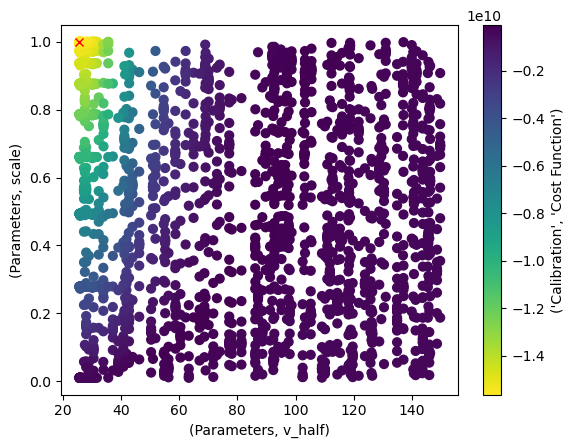

In [12]:
bayes_output.plot_p_space(x="v_half", y="scale")

And print the 'optimal' parameters

In [13]:
p_space_df["Parameters"].iloc[0, :].to_dict()

{'scale': 1.0, 'v_half': 25.81}

## Analyze the Calibration

TODO